# Beacon localization with Neural Networks - Softmax
In this project dat from all beacons are used to get the location of the device in the space GRID


In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import glob, os
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

## Load Data
Here we load all CSV files, one CSV file equaels one measurement

In [2]:
data_path = 'c:/Users/E411208/Documents/Python Scripts/data/Bluetooth/'
data = pd.DataFrame()

for id,file in enumerate(os.listdir(data_path)):
    if file.endswith(".csv"):
        print('Loading file ... ' + file)
        measurement = pd.read_csv(data_path + file)
        measurement['measurement']=id 
        data = data.append(measurement,ignore_index = True)


Loading file ... 01_stat_20170627T1723_Nexus 5X.csv
Loading file ... 02_stat_20170627T1730_Nexus 5X.csv
Loading file ... 03_stat_20170627T1736_Nexus 5X.csv
Loading file ... 04_stat_20170627T1742_Nexus 5X.csv
Loading file ... 05_stat_20170627T1748_Nexus 5X.csv
Loading file ... 06_stat_20170627T1753_Nexus 5X.csv
Loading file ... 07_stat_20170627T1759_Nexus 5X.csv
Loading file ... 08_stat_20170627T1805_Nexus 5X.csv
Loading file ... 09_stat_20170627T1812_Nexus 5X.csv
Loading file ... 10_stat_20170627T1820_Nexus 5X.csv
Loading file ... 11_stat_20170627T1826_Nexus 5X.csv
Loading file ... 12_stat_20170627T1832_Nexus 5X.csv


In [3]:
data.head()

,device_x,device_y,device_z,time,beacon_9827_x,beacon_9827_y,beacon_9827_z,beacon_9827_d,beacon_9841_x,beacon_9841_y,...,beacon_10197_d,beacon_10203_x,beacon_10203_y,beacon_10203_z,beacon_10203_d,beacon_10214_x,beacon_10214_y,beacon_10214_z,beacon_10214_d,measurement
0,22.0,3.5,1.1,2017-01-01T17:24:39,27.0,-4.5,1.1,1.98,3.0,21.0,...,1.70,18.5,19.5,1.1,NaN,13.0,19.5,1.1,NaN,0
1,22.0,3.5,1.1,2017-01-01T17:24:40,27.0,-4.5,1.1,1.80,3.0,21.0,...,1.68,18.5,19.5,1.1,NaN,13.0,19.5,1.1,NaN,0
2,22.0,3.5,1.1,2017-01-01T17:24:41,27.0,-4.5,1.1,1.52,3.0,21.0,...,1.68,18.5,19.5,1.1,NaN,13.0,19.5,1.1,NaN,0
3,22.0,3.5,1.1,2017-01-01T17:24:42,27.0,-4.5,1.1,1.52,3.0,21.0,...,1.66,18.5,19.5,1.1,NaN,13.0,19.5,1.1,NaN,0
4,22.0,3.5,1.1,2017-01-01T17:24:44,27.0,-4.5,1.1,1.51,3.0,21.0,...,1.70,18.5,19.5,1.1,NaN,13.0,19.5,1.1,NaN,0


## Space grid 
Define the location of the spaces (tables,coridors,..). Use grid defined by tiles on ceiling

<img src="img/HPL_prague.jpg" width=300px>

In [4]:
bbox_table = np.array([[17, 0, 7.5, 7],
                     [7, 0, 10, 7],
                     [0, 0, 7, 8],
                     [0, 8, 7, 8.5],
                     [0, 16.5, 7, 8.5],
                     [0 ,25, 7, 8],
                     [7, 26, 10, 7],
                     [17, 26, 10, 7],
                     [27, 26, 5.5, 7]                       
                    ])
bbox_coridor = np.array([[10, 7, 21.5, 3],
                     [7, 7, 3,19],
                     [10, 23, 21.5, 3]
                    ])
bbox_aquarium = np.array([[22, 10, 6, 6.5],
                     [16, 10, 6, 6.5],
                     [10, 10, 6, 6.5],
                     [10, 16.5, 6, 6.5],
                     [16, 16.5, 6, 6.5],
                     [22, 16.5, 6, 6.5]                          
                    ])

bbox_meet = np.array([[24.5, -10, 8.5, 11],
                     [24.5, 1, 8.5, 6],
                    ])

bbox_all = bbox_table#np.concatenate([bbox_table,bbox_coridor,bbox_aquarium])
#print(bbox_all)
nb_classes = len(bbox_all)

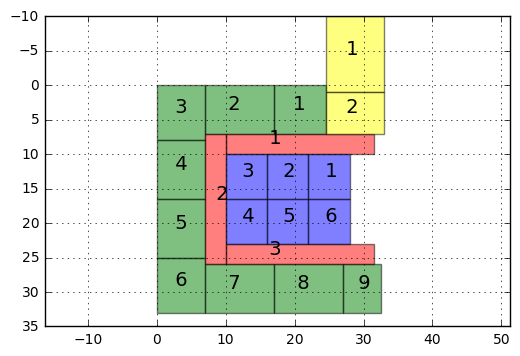

In [6]:
# visualize the grid

%matplotlib inline
import matplotlib.pyplot as plt


def visu_rectangle(ax,bbox,color,grid_id):
    ax.add_patch(plt.Rectangle((bbox[0], bbox[1]),bbox[2],bbox[3], 
        facecolor=color, alpha=0.5,edgecolor='black',linewidth=1))
    
    ax.text(bbox[0]+bbox[2]/4, bbox[1]+bbox[3]/2,
       '{:s} {:s}'.format('', grid_id),
       fontsize=14, color='black')    

    
fig, ax = plt.subplots()

for idx, bbox in enumerate(bbox_table):
    visu_rectangle(ax,bbox,'green',str(idx+1))


for idx, bbox in enumerate(bbox_coridor):
    visu_rectangle(ax,bbox,'red',str(idx+1))

for idx, bbox in enumerate(bbox_aquarium):
    visu_rectangle(ax,bbox,'blue',str(idx+1))

for idx, bbox in enumerate(bbox_meet):
    visu_rectangle(ax,bbox,'yellow',str(idx+1))

ax.invert_yaxis()  
plt.axis('equal')    
plt.grid()
plt.show()


### Add new column 'grid_id' which maps device x,y location to id of the grid define above

In [7]:
data['grid_id'] = 0
for index, row in data.iterrows():
    x,y = data.loc[index,'device_x'], data.loc[index,'device_y']
    for grid_id,bbox in enumerate(bbox_all):
        #check if the x,y point is within rectangle
        x0,y0,x1,y1 = bbox[0],bbox[1],bbox[2]+bbox[0],bbox[3]+bbox[1]
        if x0 < x < x1 and y0 < y < y1: 
            data.loc[index,'grid_id'] = grid_id

In [8]:
data.tail()

,device_x,device_y,device_z,time,beacon_9827_x,beacon_9827_y,beacon_9827_z,beacon_9827_d,beacon_9841_x,beacon_9841_y,...,beacon_10203_x,beacon_10203_y,beacon_10203_z,beacon_10203_d,beacon_10214_x,beacon_10214_y,beacon_10214_z,beacon_10214_d,measurement,grid_id
2299,3.0,30.5,1.1,2017-01-01T18:37:15,27.0,-4.5,1.1,4.87,3.0,21.0,...,18.5,19.5,1.1,NaN,13.0,19.5,1.1,NaN,11,5
2300,3.0,30.5,1.1,2017-01-01T18:37:16,27.0,-4.5,1.1,NaN,3.0,21.0,...,18.5,19.5,1.1,NaN,13.0,19.5,1.1,NaN,11,5
2301,3.0,30.5,1.1,2017-01-01T18:37:18,27.0,-4.5,1.1,4.87,3.0,21.0,...,18.5,19.5,1.1,2.23,13.0,19.5,1.1,NaN,11,5
2302,3.0,30.5,1.1,2017-01-01T18:37:20,27.0,-4.5,1.1,NaN,3.0,21.0,...,18.5,19.5,1.1,NaN,13.0,19.5,1.1,NaN,11,5
2303,3.0,30.5,1.1,2017-01-01T18:37:21,27.0,-4.5,1.1,NaN,3.0,21.0,...,18.5,19.5,1.1,NaN,13.0,19.5,1.1,NaN,11,5


## Scale data
Shift and scale the variables such that they have zero mean and a standard deviation of 1. The scaling factors are saved so we can go backwards when we use the network for predictions.

In [9]:
list_of_beacons = data.keys()[4:-1] # skip device and time and measurement
list_of_devices = [k for k in data.keys()[:3] if not('_d') in k]

list_beacon_x = [k for k in list_of_beacons if ('_x') in k]
list_beacon_y = [k for k in list_of_beacons if ('_y') in k]
list_beacon_z = [k for k in list_of_beacons if ('_z') in k]
N_beacons = len(list_beacon_x)
print('Number of beacons is ',N_beacons)


# scale the x,y,z coordinates
list_coordinates = list_of_devices + list_beacon_x + list_beacon_y + list_beacon_z  
mean_coordinates, std_coordinates = data[list_coordinates].stack().mean(), data[list_coordinates].stack().std()
data.loc[:,list_coordinates] = (data[list_coordinates] - mean_coordinates)/std_coordinates

#scale the distances 
list_beacon_d = [k for k in list_of_beacons if ('_d') in k]
mean_distances, std_distances = data[list_beacon_d].stack().mean(), data[list_beacon_d].stack().std()    
data.loc[:,list_beacon_d] = (data[list_beacon_d] - mean_distances)/std_distances

Number of beacons is  20


In [10]:
data.tail()

,device_x,device_y,device_z,time,beacon_9827_x,beacon_9827_y,beacon_9827_z,beacon_9827_d,beacon_9841_x,beacon_9841_y,...,beacon_10203_x,beacon_10203_y,beacon_10203_z,beacon_10203_d,beacon_10214_x,beacon_10214_y,beacon_10214_z,beacon_10214_d,measurement,grid_id
2299,-0.782355,1.575441,-0.945257,2017-01-01T18:37:15,1.275358,-1.42539,-0.945257,1.705749,-0.782355,0.76093,...,0.546585,0.632323,-0.945257,NaN,0.075026,0.632323,-0.945257,NaN,11,5
2300,-0.782355,1.575441,-0.945257,2017-01-01T18:37:16,1.275358,-1.42539,-0.945257,NaN,-0.782355,0.76093,...,0.546585,0.632323,-0.945257,NaN,0.075026,0.632323,-0.945257,NaN,11,5
2301,-0.782355,1.575441,-0.945257,2017-01-01T18:37:18,1.275358,-1.42539,-0.945257,1.705749,-0.782355,0.76093,...,0.546585,0.632323,-0.945257,-0.101191,0.075026,0.632323,-0.945257,NaN,11,5
2302,-0.782355,1.575441,-0.945257,2017-01-01T18:37:20,1.275358,-1.42539,-0.945257,NaN,-0.782355,0.76093,...,0.546585,0.632323,-0.945257,NaN,0.075026,0.632323,-0.945257,NaN,11,5
2303,-0.782355,1.575441,-0.945257,2017-01-01T18:37:21,1.275358,-1.42539,-0.945257,NaN,-0.782355,0.76093,...,0.546585,0.632323,-0.945257,NaN,0.075026,0.632323,-0.945257,NaN,11,5


## Train/Validation/Test set
The data are split in 3 datasets. From each measurement use 80% is for training, 10% for validation and 10% for testing

In [11]:
train = pd.DataFrame()
valid = pd.DataFrame()
test = pd.DataFrame()

for measurement in range(0,data['measurement'].max()+1):
    subdata = data[data['measurement'] == measurement]
    length = len(subdata.index)
    train_idx = int(length*0.8)
    valid_idx = int(length*0.9)
    train = train.append(subdata.iloc[:train_idx])
    valid = valid.append(subdata.iloc[train_idx:valid_idx])
    test  = test.append(subdata.iloc[valid_idx:])


In [12]:
print(len(data.index),'All data lines')
print(len(train.index),'Training data lines')
print(len(valid.index),'Validation data lines')
print(len(test.index),'Testing data lines')

2304 All data lines
1837 Training data lines
228 Validation data lines
239 Testing data lines


## Data Cleansing
Every timestamp has various number of beacon measurements (3-20). The input to the network will take information from ALL beacons and try to predict the location of the device.  The becons with distance equal to NaN will have cooridnates set to 0

How many beacons is required to get descent output?

In [13]:
from itertools import combinations

def augmented_data(in_data):
    out_data_x = list()
    out_data_y = list()
    for index, row in in_data.iterrows():
        if index % 100 == 0: print('Number of processed rows ...',index)
        
        # set zero to beacons coordinates & distance if distance == NaN 
        out_data_y.extend(np.eye(nb_classes)[row['grid_id']])

        for idx,beacon in enumerate(list_beacon_d):
            if pd.isnull(row[beacon]):
                out_data_x.extend([0,0,0,0])
            else:    
                out_data_x.extend([row[list_beacon_x[idx]],row[list_beacon_y[idx]],row[list_beacon_z[idx]],row[list_beacon_d[idx]]])

    out_data_x = np.reshape(out_data_x,[-1,N_beacons*4]) #all 20 beacons [x,y,z,d]            
    out_data_y = np.reshape(out_data_y,[-1,nb_classes]) # device [x,y,z]
    return out_data_x,out_data_y
                

#augmented_data(train[:1])
train_x,train_y = augmented_data(train)
val_x,val_y = augmented_data(valid)
test_x,test_y = augmented_data(test)

Number of processed rows ... 0
Number of processed rows ... 100
Number of processed rows ... 200
Number of processed rows ... 300
Number of processed rows ... 400
Number of processed rows ... 500
Number of processed rows ... 600
Number of processed rows ... 700
Number of processed rows ... 800
Number of processed rows ... 900
Number of processed rows ... 1000
Number of processed rows ... 1100
Number of processed rows ... 1200
Number of processed rows ... 1300
Number of processed rows ... 1400
Number of processed rows ... 1600
Number of processed rows ... 1800
Number of processed rows ... 2000
Number of processed rows ... 2200
Number of processed rows ... 1500
Number of processed rows ... 1700
Number of processed rows ... 1900
Number of processed rows ... 2100
Number of processed rows ... 2300


In [14]:
print(train.shape)
print(train_y.shape)
print(train_x.shape)
print(val_x.shape)
print(test_x.shape)

(1837, 86)
(1837, 9)
(1837, 80)
(228, 80)
(239, 80)


### save the data

In [15]:
np.save('test_x',test_x)
np.save('test_y',test_y)

# Neural Network
Construct a network that takes on input signals from 3 beacons and their x,y,z coordinates + distance, have one nonlinear hidden layer and output x,y,z, coordinates of the device

In [16]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

x = tf.placeholder('float32',[None,N_beacons*4])
y = tf.placeholder('float32',[None,nb_classes])
learning_rate = 0.001;
num_outputs = nb_classes;

#####################################
## Create the Neural Network Model ##
#####################################

def fully_conn(input, hiddens):
    input_shape = input.get_shape().as_list()
    std_init = 1/np.sqrt(input_shape[1])
    weight = tf.Variable(tf.truncated_normal([input_shape[1],hiddens], stddev=std_init)) 
    bias = tf.Variable(tf.constant(0.1, shape=[hiddens]))
    full_bias = tf.add(tf.matmul(input,weight),bias,name='full_bias')
    return tf.nn.elu(full_bias,name='fc_relu')

def output(input, num_outputs):
    input_shape = input.get_shape().as_list()
    std_init = 1/np.sqrt(input_shape[1])
    weight = tf.Variable(tf.truncated_normal([input_shape[1],num_outputs], stddev=std_init)) 
    return tf.matmul(input,weight, name='output')    

def network(input,num_outputs):
    hidden1 = fully_conn(input,20) # 20
    hidden2 = fully_conn(hidden1,50) # 50
    hidden3 = fully_conn(hidden2,100) # 100
    out = output(hidden3,num_outputs)
    return out

##############################
## Build the Neural Network ##
##############################

# Model
logits =  network(x,num_outputs)


# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Prepare batches for training

In [17]:
def get_batches(x, y, n_batches=20):
    """ Return a generator that yields batches from arrays x and y. """
    batch_size = len(x)//n_batches
    
    for ii in range(0, n_batches*batch_size, batch_size):
        # If we're not on the last batch, grab data with size batch_size
        if ii != (n_batches-1)*batch_size:
            X, Y = x[ii: ii+batch_size], y[ii: ii+batch_size] 
        # On the last batch, grab the rest of the data
        else: X, Y = x[ii:], y[ii:]
        # I love generators
        yield X, Y

## Network training

In [29]:
epochs = 100
iteration = 0
saver = tf.train.Saver()
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for t_x, t_y in get_batches(train_x, train_y):
            feed = {x: t_x.astype(np.float32), 
                    y: t_y.astype(np.float32)}
            loss, _ = sess.run([cost, optimizer], feed_dict=feed)
#             print("Epoch: {}/{}".format(e+1, epochs),
#                   "Iteration: {}".format(iteration),
#                   "Training loss: {:.5f}".format(loss))
            iteration += 1
            
            if iteration % 100 == 0:
                feed = {x: val_x,
                        y: val_y}
                val_loss,val_acc = sess.run([cost, accuracy], feed_dict=feed)
                print("Epoch: {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Training loss: {:.5f}".format(loss),
                      "Validation loss: {:.5f}".format(val_loss),
                      "Validation Acc: {:.4f}".format(val_acc))
    saver.save(sess, "checkpoints-softmax/dev_loc.ckpt")

Epoch: 4/100 Iteration: 100 Training loss: 1.44356 Validation loss: 1.23987 Validation Acc: 0.6316
Epoch: 9/100 Iteration: 200 Training loss: 0.75226 Validation loss: 0.69160 Validation Acc: 0.7982
Epoch: 14/100 Iteration: 300 Training loss: 0.56775 Validation loss: 0.47165 Validation Acc: 0.8640
Epoch: 19/100 Iteration: 400 Training loss: 0.44911 Validation loss: 0.33980 Validation Acc: 0.9035
Epoch: 24/100 Iteration: 500 Training loss: 0.37624 Validation loss: 0.25776 Validation Acc: 0.9298
Epoch: 29/100 Iteration: 600 Training loss: 0.33161 Validation loss: 0.21037 Validation Acc: 0.9342
Epoch: 34/100 Iteration: 700 Training loss: 0.29738 Validation loss: 0.25084 Validation Acc: 0.9035
Epoch: 39/100 Iteration: 800 Training loss: 0.79973 Validation loss: 1.14359 Validation Acc: 0.6579
Epoch: 44/100 Iteration: 900 Training loss: 0.20689 Validation loss: 0.33263 Validation Acc: 0.8860
Epoch: 49/100 Iteration: 1000 Training loss: 0.23879 Validation loss: 0.20856 Validation Acc: 0.9430
E

## Save the network to numpy

In [ ]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-softmax'))
    for v in tf.trainable_variables():
        print(v)
    
    var = [v for v in tf.trainable_variables() if v.name == "Variable:0"][0]
    weight_1 = sess.run(var)
    np.save('checkpoints-softmax-numpy/weight_1',weight_1)
    
    var = [v for v in tf.trainable_variables() if v.name == "Variable_1:0"][0]
    bias_1  = sess.run(var)
    np.save('checkpoints-softmax-numpy/bias_1',bias_1)
    
    var = [v for v in tf.trainable_variables() if v.name == "Variable_2:0"][0]
    weight_2 = sess.run(var)
    np.save('checkpoints-softmax-numpy/weight_2',weight_2)
    
    var = [v for v in tf.trainable_variables() if v.name == "Variable_3:0"][0]
    bias_2 = sess.run(var)
    np.save('checkpoints-softmax-numpy/bias_2',bias_2)
    
    var = [v for v in tf.trainable_variables() if v.name == "Variable_4:0"][0]
    weight_3 = sess.run(var)
    np.save('checkpoints-softmax-numpy/weight_3',weight_3)
    
    var = [v for v in tf.trainable_variables() if v.name == "Variable_5:0"][0]
    bias_3 = sess.run(var)
    np.save('checkpoints-softmax-numpy/bias_3',bias_3)

    var = [v for v in tf.trainable_variables() if v.name == "Variable_6:0"][0]
    output = sess.run(var)
    np.save('checkpoints-softmax-numpy/output',output)

    

## Check the result on testing data 
load the trained model and run it

In [245]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-softmax'))
    
    feed = {x: test_x,
            y: test_y}

    out = sess.run(tf.nn.softmax(logits), feed_dict=feed)
    
    out_test_y =sess.run(tf.argmax(out, axis=1))
    label_test_y = sess.run(tf.argmax(test_y, axis=1))
    test_los,test_acc = sess.run([cost,accuracy], feed_dict=feed)
    print("Test accuracy: {:.4f}%".format(test_acc*100))

INFO:tensorflow:Restoring parameters from checkpoints-softmax\dev_loc.ckpt
Test accuracy: 95.3975%


In [133]:
confidence_test = np.amax(out,axis=1)
for i,val in enumerate(out_y):
    print(out_test_y[i],' - ',confidence_test[i])

0  -  1.0
0  -  1.0
0  -  0.773609
0  -  0.672007
0  -  0.999624
0  -  1.0
0  -  1.0
0  -  1.0
0  -  1.0
0  -  1.0
0  -  1.0
0  -  1.0
0  -  1.0
0  -  0.999272
0  -  0.999999
0  -  0.999994
0  -  1.0
0  -  1.0
0  -  1.0
0  -  1.0
0  -  0.999982
0  -  0.999981
0  -  0.993679
0  -  1.0
0  -  0.723231
0  -  1.0
0  -  0.999985
0  -  0.999999
0  -  1.0
0  -  0.999999
0  -  0.999998
0  -  0.999982
0  -  1.0
0  -  1.0
0  -  1.0
0  -  0.432229
0  -  0.999995
0  -  1.0
0  -  0.999979
1  -  0.999811
1  -  0.99933
1  -  0.739297
1  -  0.991968
1  -  0.999786
1  -  0.999951
1  -  0.998075
1  -  0.987448
1  -  0.999986
1  -  0.599622
1  -  0.999144
1  -  0.999917
1  -  0.999167
1  -  0.887302
1  -  0.999831
1  -  0.983549
1  -  0.999903
1  -  0.999981
1  -  0.999042
1  -  0.999987
1  -  0.997647
1  -  0.999769
1  -  0.99593
0  -  0.678017
1  -  0.999821
1  -  0.998049
1  -  0.999398
1  -  0.999664
1  -  0.998244
1  -  0.999685
1  -  0.999855
1  -  0.768578
1  -  0.999686
1  -  0.999585
5  -  0.4074

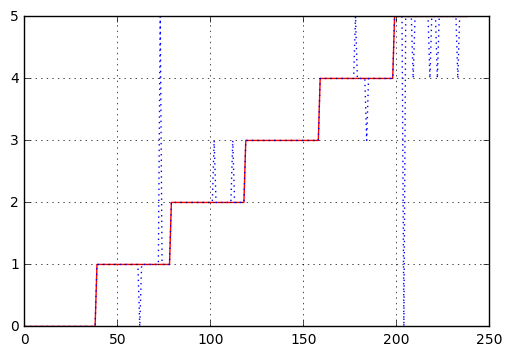

In [33]:
plt.plot(range(0,239), label_y,'r')
plt.plot(range(0,239), out_y,':')
plt.grid()

## Find Confidence Threshold on Training data to increase Test accuracy 
show the lowest confidence for correct output
show the highest confidence for wrong output

BUT keep the number of correct prediction at 95%

In [244]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints-softmax'))
    
    feed = {x: train_x,
            y: train_y}

    out = sess.run(tf.nn.softmax(logits), feed_dict=feed)
    
    out_train_y =sess.run(tf.argmax(out, axis=1))
    label_train_y = sess.run(tf.argmax(train_y, axis=1))
    test_los,test_acc = sess.run([cost,accuracy], feed_dict=feed)
    print("Train accuracy: {:.4f}%".format(test_acc*100))

INFO:tensorflow:Restoring parameters from checkpoints-softmax\dev_loc.ckpt
Train accuracy: 97.7137


In [191]:
confidence_train = np.amax(out,axis=1)
ind_train_correct = list()
ind_train_wrong = list()
for ind,val in enumerate(out_train_y):
    if val == label_train_y[ind]:
        ind_train_correct.append(ind)
    else:
        ind_train_wrong.append(ind)

print('show the lowest confidence for correct output',
      confidence_train[ind_train_correct].min())
print('show the lowest/highest confidence for wrong output',
      confidence_train[ind_train_wrong].min(),' ',confidence_train[ind_train_wrong].max())

show the lowest confidence for correct output 0.347125
show the lowest/highest confidence for wrong output 0.283276   0.920838


In [243]:
for val in range(50,81,5):
    T = val/100
    
    grid_correct = np.sum(confidence_train[ind_train_correct]<T)
    grid_wrong = np.sum(confidence_train[ind_train_wrong]<T)
    percent_correct = 100*grid_correct/len(confidence_train[ind_train_correct])
    percent_wrong = 100*grid_wrong/len(confidence_train[ind_train_wrong])
    percent_all = 100*(grid_correct+ grid_wrong)/len(confidence_train)
    print('For threshold {0:.2f} ({1:.2f}% data removed)'.format(T,percent_all))
    print('{0} item {1:.1f}% correct removed'.format(grid_correct,percent_correct))
    print('{0} item {1:.1f}% wrong removed'.format(grid_wrong,percent_wrong))
    print()

For threshold 0.50 (1.52% data removed)
11 item 0.6% correct removed
17 item 40.5% wrong removed

For threshold 0.55 (2.72% data removed)
27 item 1.5% correct removed
23 item 54.8% wrong removed

For threshold 0.60 (3.76% data removed)
39 item 2.2% correct removed
30 item 71.4% wrong removed

For threshold 0.65 (4.57% data removed)
50 item 2.8% correct removed
34 item 81.0% wrong removed

For threshold 0.70 (6.04% data removed)
73 item 4.1% correct removed
38 item 90.5% wrong removed

For threshold 0.75 (7.02% data removed)
91 item 5.1% correct removed
38 item 90.5% wrong removed

For threshold 0.80 (7.89% data removed)
107 item 6.0% correct removed
38 item 90.5% wrong removed



how many percent of correct wrong output is removed for selected threshold

# SET THRESHOLD

In [235]:
T = 0.75

# Training data results

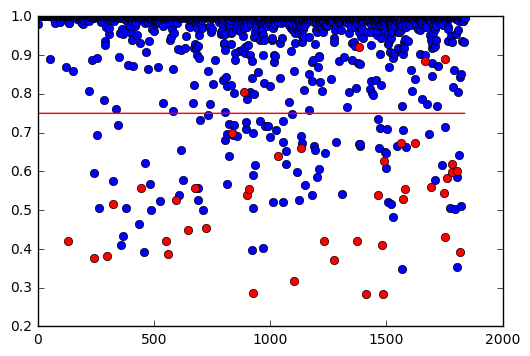

In [236]:
plt.plot(ind_train_correct,confidence_train[ind_train_correct],linestyle='None',marker='o',color='b')
plt.plot(ind_train_wrong,confidence_train[ind_train_wrong],linestyle='None',marker='o',color='r')
plt.plot(np.ones(len(confidence_train))*T,color='r')

In [237]:
ind_correct = list()
ind_wrong = list()
ind_all = list()
ind_removed = list()
for ind,val in enumerate(out_train_y):
    if confidence_train[ind] > T:
        ind_all.append(ind)
        if val == label_train_y[ind]:
            ind_correct.append(ind)
        else:
            ind_wrong.append(ind)
    else:
        ind_removed.append(ind)
            
precision = 100*len(ind_correct)/len(ind_all)            
percent_removed = 100*len(ind_removed)/len(confidence_train)
print('The precission on training data is {0:.2f}, for T={1:.2f} (with {2:0.1f}% data removed)'.format(precision,T,percent_removed))

The precission on training data is 99.77, for T=0.75 (with 7.0% data removed)


# Testing data results

In [238]:
ind_test_correct = list()
ind_test_wrong = list()
for ind,val in enumerate(out_test_y):
    if val == label_test_y[ind]:
        ind_test_correct.append(ind)
    else:
        ind_test_wrong.append(ind)

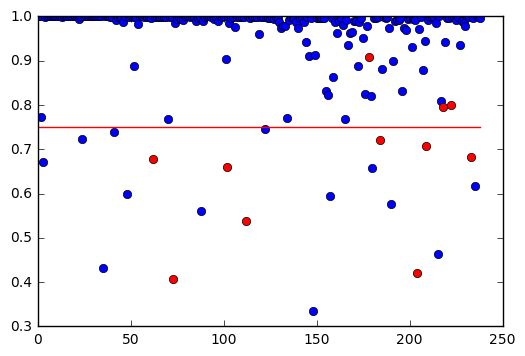

In [239]:
plt.plot(ind_test_correct,confidence_test[ind_test_correct],linestyle='None',marker='o',color='b')
plt.plot(ind_test_wrong,confidence_test[ind_test_wrong],linestyle='None',marker='o',color='r')
plt.plot(np.ones(len(confidence_test))*T,color='r')

In [240]:
ind_correct = list()
ind_wrong = list()
ind_all = list()
ind_removed = list()
for ind,val in enumerate(out_test_y):
    if confidence_test[ind] > T:
        ind_all.append(ind)
        if val == label_test_y[ind]:
            ind_correct.append(ind)
        else:
            ind_wrong.append(ind)
    else:
        ind_removed.append(ind)
            
precision = 100*len(ind_correct)/len(ind_all)            
percent_removed = 100*len(ind_removed)/len(confidence_test)
print('The precission on testing data is {1:.2f}, for T={0:.2f} (with {2:0.1f}% data removed)'.format(T,precision,percent_removed))

The precission on testing data is 98.62, for T=0.75 (with 8.8% data removed)
